In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !cd '/content/drive/My Drive/Colab Notebooks/COMP596/project' && git clone https://github.com/stellargraph/stellargraph.git
!cd '/content/drive/My Drive/Colab Notebooks/COMP596/project/stellargraph' && pip3 install .
!cd '/content/drive/My Drive/Colab Notebooks/COMP596/project/stellargraph' && pip3 install .[demos]
# !pip3 install stellargraph
# !pip3 install stellargraph[link-prediction]
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/COMP596/project/utils')

Processing /content/drive/My Drive/Colab Notebooks/COMP596/project/stellargraph
     |████████████████████████████████| 109.2MB 113kB/s 
     |████████████████████████████████| 3.2MB 30.6MB/s 
     |████████████████████████████████| 491kB 47.1MB/s 
  Created wheel for stellargraph: filename=stellargraph-0.9.0b0-cp36-none-any.whl size=180400 sha256=e33907bd0ac95d0d4e3ef76706daea3d8160ddc10916e8a4e9fedac88bb8d87b
  Stored in directory: /tmp/pip-ephem-wheel-cache-e0puy9f4/wheels/f9/3e/88/02cbb1e1461628624b4d33f2a263bbe06bc8a9ceff4aaccd0c
Successfully built stellargraph
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow

In [0]:
# if you want to suppress warnings 
import warnings
warnings.filterwarnings("ignore")

import os
import random
from operator import itemgetter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from scipy import sparse

from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, mean_absolute_error, mean_squared_error
from sklearn import preprocessing, feature_extraction, model_selection

import networkx as nx
from networkx.algorithms import bipartite

import stellargraph as sg
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_classification
from tensorflow.keras import Model, optimizers, losses
from tensorflow.keras import metrics as keras_metrics

import multiprocessing

PROJECT_DIR = os.path.abspath('/content/drive/My Drive/Colab Notebooks/COMP596/project')
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
ML_1M_DIR = os.path.join(DATA_DIR, 'ml-1m')

In [0]:
from utils import create_movielens_graph, load_movies_formatted, apply_features, load_users, delete_bipartite_attribute, sample, create_user_features

In [0]:
graph = create_movielens_graph(ML_1M_DIR)

In [0]:
user_df = load_users(ML_1M_DIR)
user_features = create_user_features(user_df)
movie_features = load_movies_formatted(ML_1M_DIR)

In [0]:
graph = apply_features(graph, user_features, bipartite_set='u')
graph = apply_features(graph, movie_features, bipartite_set='m')
del user_features, movie_features

In [0]:
users, movies = bipartite.sets(graph)
non_edges = [edge for edge in list(nx.non_edges(graph)) if edge[0] in users and edge[1] in movies]
sampled_non_edges = sample(non_edges, num_samples=graph.number_of_edges())
sampled_non_edges = [(edge[0], edge[1], {'rating': 0}) for edge in sampled_non_edges]

edges = list(graph.edges(data=True))
edges.extend(sampled_non_edges)
del non_edges, sampled_non_edges

In [0]:
edges = [(edge[0], edge[1], {'rating': 1 if edge[2]['rating'] > 0 else 0}) for edge in edges]

In [0]:
# 80% Train, 10% Val, 10% Test
edges_train, edges_test = model_selection.train_test_split(edges, train_size=0.8, random_state=42)
edges_val, edges_test = model_selection.train_test_split(edges_test, train_size=0.5, random_state=42)

edgelist_train = [(e[0],e[1]) for e in edges_train]
edgelist_val = [(e[0],e[1]) for e in edges_val]
edgelist_test = [(e[0],e[1]) for e in edges_test]

labels_train = [e[2]["rating"] for e in edges_train]
labels_val = [e[2]["rating"] for e in edges_val]
labels_test = [e[2]["rating"] for e in edges_test]

In [0]:
# When sampling the GraphSAGE subgraphs, we want to treat user-movie links as undirected
G = sg.StellarGraph(graph, node_features="feature")

In [0]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 9746, Edges: 1000209

 Node types:
  movie: [3706]
        Attributes: {'feature', 'bipartite'}
    Edge types: movie-default->user
  user: [6040]
        Attributes: {'feature', 'bipartite'}
    Edge types: user-default->movie

 Edge types:
    user-default->movie: [1000209]
        Attributes: {'rating'}



In [0]:
batch_size = 64

In [0]:
num_samples =  [8, 4]

In [0]:
generator = HinSAGELinkGenerator(
            G,
            batch_size,
            num_samples,
            head_node_types=['user', 'movie']
        )

gen_train = generator.flow(edgelist_train, labels_train, shuffle=True)
gen_val = generator.flow(edgelist_val, labels_val, shuffle=True)
gen_test = generator.flow(edgelist_test, labels_test)

In [0]:
hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(layer_sizes=hinsage_layer_sizes, 
                  generator=generator, 
                  bias=True, 
                  dropout=0.00)

In [0]:
# Expose input and output sockets of hinsage:
x_inp, x_out = hinsage.build()

In [0]:
# Final estimator layer
# score_prediction = link_regression(edge_embedding_method='concat')(x_out)
score_prediction = link_classification(output_act='relu', edge_embedding_method='ip')(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [0]:
import tensorflow.keras.backend as K
def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))

model = Model(inputs=x_inp, outputs=score_prediction)
model.compile(
    optimizer=optimizers.Adam(lr=1e-2),
    loss=losses.mean_squared_error,
    metrics=[keras_metrics.binary_accuracy]
)

Run [0]
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
link_classification: using 'ip' method to combine node embeddings into edge embeddings
Epoch 1/3
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
25006/25006 [==============================] - 884s 35ms/step - loss: 0.1886 - binary_accuracy: 0.7112 - val_loss: 0.1836 - val_binary_accuracy: 0.7226
Epoch 2/3
25006/25006 [==============================] - 847s 34ms/step - loss: 0.1833 - binary_accuracy: 0.7225 - val_loss: 0.1821 - val_binary_accuracy: 0.7251
Epoch 3/3
25006/25006 [==============================] - 857s 34ms/step - loss: 0.1819 - binary_accuracy: 0.7255 - val_loss: 0.1812 - val_binary_accuracy: 0.7262
Time to train 2588.2227625846863 seconds


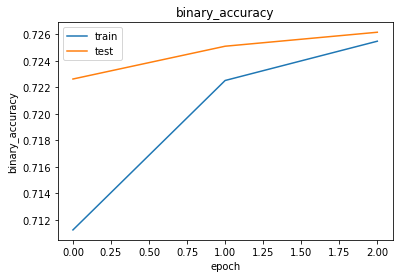

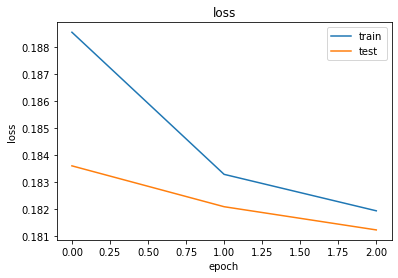

3126/3126 [==============================] - 102s 33ms/step - loss: 0.1812 - binary_accuracy: 0.7261
Test Evaluation:
	loss: 0.1812
	binary_accuracy: 0.7261


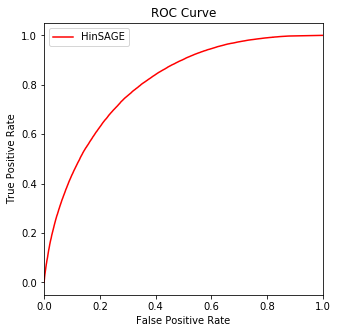

ROC Auc = 0.8044
ROC AUC: 0.8044334464442873
Run [1]
link_classification: using 'ip' method to combine node embeddings into edge embeddings
Epoch 1/3
25006/25006 [==============================] - 763s 30ms/step - loss: 0.1891 - binary_accuracy: 0.7104 - val_loss: 0.1842 - val_binary_accuracy: 0.7206
Epoch 2/3
25006/25006 [==============================] - 758s 30ms/step - loss: 0.1841 - binary_accuracy: 0.7209 - val_loss: 0.1833 - val_binary_accuracy: 0.7222
Epoch 3/3
25006/25006 [==============================] - 747s 30ms/step - loss: 0.1831 - binary_accuracy: 0.7229 - val_loss: 0.1831 - val_binary_accuracy: 0.7228
Time to train 2268.324670314789 seconds


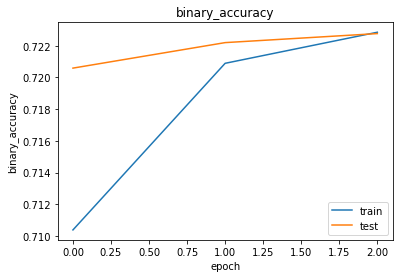

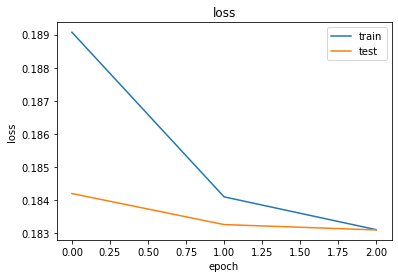

3126/3126 [==============================] - 76s 24ms/step - loss: 0.1825 - binary_accuracy: 0.7240
Test Evaluation:
	loss: 0.1825
	binary_accuracy: 0.7240


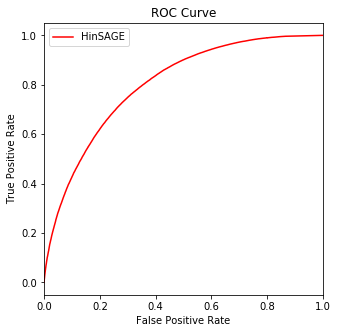

ROC Auc = 0.8008
ROC AUC: 0.8008320639926568
Run [2]
link_classification: using 'ip' method to combine node embeddings into edge embeddings
Epoch 1/3
25006/25006 [==============================] - 752s 30ms/step - loss: 0.1885 - binary_accuracy: 0.7114 - val_loss: 0.1838 - val_binary_accuracy: 0.7215
Epoch 2/3
13024/25006 [==============>...............] - ETA: 5:16 - loss: 0.1840 - binary_accuracy: 0.7211

In [0]:
import matplotlib.pyplot as plt
import time
%matplotlib inline

import tensorflow.keras.backend as K
def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))

def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='best')
        plt.show()


def run_evaluation(predictions, truth):
    curve_args = []
#     pdb.set_trace()
    roc_auc = roc_auc_score(predictions, truth)
    fpr, tpr, t = roc_curve(predictions, truth)
    
#     COLORS = ['r', 'b', 'g', 'm', 'y', 'c', 'k', '#FF9900', '#006600', '#663300']
#     curve_args.append((fpr, tpr, COLORS[i % len(COLORS)]))
    curve_args.append((fpr, tpr, 'r'))

    plt.figure(figsize=(5, 5))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.title('ROC Curve')
    for (fpr, tpr, color) in curve_args:
        plt.plot(fpr, tpr, label='HinSAGE', color=color)
    plt.legend(loc="best")
    plt.show()

    print (f"ROC Auc = {roc_auc:.4f}")


# When sampling the GraphSAGE subgraphs, we want to treat user-movie links as undirected
G = sg.StellarGraph(graph, node_features="feature")
batch_size = 64
num_samples =  [8, 4]
hinsage_layer_sizes = [32, 32]
generator = HinSAGELinkGenerator(
            G,
            batch_size,
            num_samples,
            head_node_types=['user', 'movie']
        )
num_workers = multiprocessing.cpu_count()
scores = []
for i in range(3):
    print(f'Run [{i}]')
    # 80% Train, 10% Val, 10% Test
    edges_train, edges_test = model_selection.train_test_split(edges, train_size=0.8, random_state=42)
    edges_val, edges_test = model_selection.train_test_split(edges_test, train_size=0.5, random_state=42)

    edgelist_train = [(e[0],e[1]) for e in edges_train]
    edgelist_val = [(e[0],e[1]) for e in edges_val]
    edgelist_test = [(e[0],e[1]) for e in edges_test]

    labels_train = [e[2]["rating"] for e in edges_train]
    labels_val = [e[2]["rating"] for e in edges_val]
    labels_test = [e[2]["rating"] for e in edges_test]

    gen_train = generator.flow(edgelist_train, labels_train, shuffle=True)
    gen_val = generator.flow(edgelist_val, labels_val, shuffle=True)
    gen_test = generator.flow(edgelist_test, labels_test)

    hinsage = HinSAGE(layer_sizes=hinsage_layer_sizes, 
                  generator=generator, 
                  bias=True, 
                  dropout=0.00)
    # Expose input and output sockets of hinsage:
    x_inp, x_out = hinsage.build()
    score_prediction = link_classification(output_act='relu', edge_embedding_method='ip')(x_out)

    model = Model(inputs=x_inp, outputs=score_prediction)
    model.compile(
        optimizer=optimizers.Adam(lr=1e-2),
        loss=losses.mean_squared_error,
        metrics=[keras_metrics.binary_accuracy]
    )

    epochs = 3
    start = time.time()
    history = model.fit_generator(
                gen_train,
                validation_data=gen_test,
                epochs=epochs,
                verbose=1,
                shuffle=False,
                use_multiprocessing=True,
                workers=num_workers,
            )
    end = time.time() - start
    print(f'Time to train {end} seconds')
    plot_history(history)
    test_metrics = model.evaluate_generator(gen_test, use_multiprocessing=True, workers=num_workers, 
                                        verbose=1)
    print("Test Evaluation:")
    for name, val in zip(model.metrics_names, test_metrics):
        print("\t{}: {:0.4f}".format(name, val))

    y_true = labels_test
    # Predict the rankings using the model:
    y_pred = model.predict_generator(gen_test)
    run_evaluation(y_true, y_pred)
    
    score = roc_auc_score(y_true, y_pred)
    print(f'ROC AUC: {score}')
    
    scores.append(score)
print(f'Average Score over {epochs} epochs: {np.average(scores)}')

In [0]:
num_workers = multiprocessing.cpu_count()

In [0]:
# test_metrics = model.evaluate_generator(gen_test, verbose=1, use_multiprocessing=True, workers=num_workers)
test_metrics = model.evaluate_generator(gen_test, verbose=1, use_multiprocessing=True, workers=num_workers)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

12503/12503 [==============================] - 112s 9ms/step - loss: 0.4160 - binary_accuracy: 0.5007
Untrained model's Test Evaluation:
	loss: 0.4160
	binary_accuracy: 0.5007


In [0]:
epochs = 3
history = model.fit_generator(
            gen_train,
            validation_data=gen_test,
            epochs=epochs,
            verbose=1,
            shuffle=False,
            use_multiprocessing=True,
            workers=num_workers,
        )

Epoch 1/3
25006/25006 [==============================] - 854s 34ms/step - loss: 0.1888 - binary_accuracy: 0.7108 - val_loss: 0.1847 - val_binary_accuracy: 0.7206
Epoch 2/3
25006/25006 [==============================] - 834s 33ms/step - loss: 0.1835 - binary_accuracy: 0.7222 - val_loss: 0.1820 - val_binary_accuracy: 0.7249
Epoch 3/3
25006/25006 [==============================] - 810s 32ms/step - loss: 0.1823 - binary_accuracy: 0.7246 - val_loss: 0.1812 - val_binary_accuracy: 0.7271


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='best')
        plt.show()

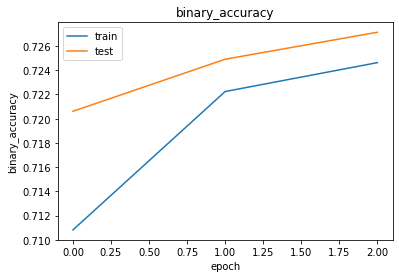

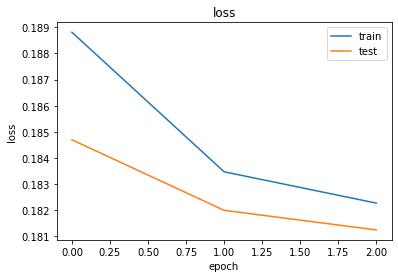

In [0]:
plot_history(history)

In [0]:
test_metrics = model.evaluate_generator(gen_test, use_multiprocessing=True, workers=num_workers, 
                                        verbose=1)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

3126/3126 [==============================] - 80s 26ms/step - loss: 0.1820 - binary_accuracy: 0.7243
Test Evaluation:
	loss: 0.1820
	binary_accuracy: 0.7243


In [0]:
y_true = labels_test
# Predict the rankings using the model:
y_pred = model.predict_generator(gen_test)

In [0]:
score = roc_auc_score(y_true, y_pred)
print(f'ROC AUC: {score}')

ROC AUC: 0.8032536160072924


In [0]:
def run_evaluation(predictions, truth):
    curve_args = []
#     pdb.set_trace()
    roc_auc = roc_auc_score(predictions, truth)
    fpr, tpr, t = roc_curve(predictions, truth)
    
#     COLORS = ['r', 'b', 'g', 'm', 'y', 'c', 'k', '#FF9900', '#006600', '#663300']
#     curve_args.append((fpr, tpr, COLORS[i % len(COLORS)]))
    curve_args.append((fpr, tpr, 'r'))

    plt.figure(figsize=(5, 5))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.title('ROC Curve')
    for (fpr, tpr, color) in curve_args:
        plt.plot(fpr, tpr, label='HinSAGE', color=color)
    plt.legend(loc="best")
    plt.show()

    print (f"ROC Auc = {roc_auc:.4f}")

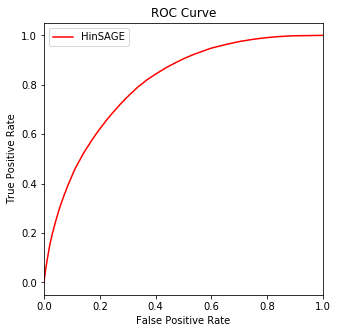

ROC Auc = 0.8033


In [0]:
run_evaluation(y_true, y_pred)